In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy.integrate import simpson
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import statsmodels as sm

In [2]:
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}



save_folder = 'Data/Crack_Arrest_Notebook_Saves/'

In [3]:
if not os.path.exists(save_folder):
    # The folder does not exist, so create it
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' was created.")
else:
    # The folder exists, so do nothing
    print('folder already exists!')

folder already exists!


In [4]:
def find_upper_yield_strength(data, prominence_factor=.01, drop_threshold=0.05):
    # Calculate the prominence based on the maximum stress observed
    prominence = data['stress'].max() * prominence_factor
    
    # Identify peaks in the stress data
    peaks, _ = find_peaks(data['stress'], prominence=prominence, threshold=drop_threshold)
    
    for peak in peaks:
        peak_stress = data.iloc[peak]['stress']
        # Search for a significant drop within the next few data points
        for i in range(peak+1, len(data)):
            if data.iloc[i]['stress'] <= peak_stress * (1 - drop_threshold):
                # Found a substantial failure
                return data.iloc[peak]['stress'], data.iloc[peak]['strain']
    
    return None, None  # In case no substantial failure is found
def find_all_relevant_peaks(data, prominence_factor=0.01):
    # Calculate the prominence based on the maximum stress observed
    prominence = data['stress'].max() * prominence_factor
    
    # Identify peaks in the stress data
    peaks, _ = find_peaks(data['stress'], prominence=prominence)
    
    # Use list comprehension to create a list of tuples with stress and strain values for each peak
    return [(data.iloc[peak]['stress'], data.iloc[peak]['strain']) for peak in peaks]

def extract_run_number(folder_name):
    """Extract the numerical part of the test run from the folder name."""
    match = re.search(r'Test Run (\d+)', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None  # In case the folder name does not match the expected format

# Original length in m
L0 = 36.0 * 10**-3

# Cross-sectional area in square m (30mm x 30mm)
area = 30*(10**-3) * 30*(10**-3)

# Set your main directory here
main_folder_path = 'Data/MTS_Runs'

# List all subdirectories in the main directory
subfolders = [os.path.join(main_folder_path, f.name) for f in os.scandir(main_folder_path) if f.is_dir()]

# Filter and sort the subfolders based on the run number
filtered_subfolders = []
for folder in subfolders:
    run_number = extract_run_number(os.path.basename(folder))
    if run_number:
        filtered_subfolders.append((folder, run_number))

In [5]:
# Sort the folders based on the extracted run number
filtered_subfolders.sort(key=lambda x: x[1])

# Initialize a list to store the toughness and peak counts for each run
toughness_and_peak_counts = []
strengths = []
# Assuming you want to dynamically generate combinations for demonstration
# Adjust these ranges as necessary to fit your actual criteria
prominence_factors = np.linspace(0.01, .25, 1000)  # Adjust the start, stop, and num values

# Ensure we have 50 combinations
assert len(prominence_factors) >= 50, "Not enough combinations"

# Now process each filtered and sorted folder
for folder, run_number in filtered_subfolders:
    # Construct the file path
    file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    
    # Check if the file exists before trying to read it
    if os.path.isfile(file_path):
        # Read the data
        data = pd.read_csv(file_path, sep='\t', skiprows=7)
        
        # Calculate strain and stress
        data['strain'] = data['mm'] * (10**-3) / L0
        data['stress'] = (data['kN'] * 1000) / area

        # Calculate toughness using Simpson's rule for numerical integration
        toughness = simpson(y=data['stress'], x=data['strain'])


        relevant_peaks_dict = {}
        peak_counts = []
        for prom in prominence_factors:
            relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
            num_peaks = len(relevant_peaks)
            peak_counts.append(num_peaks)
            relevant_peaks_dict[(prom)] = relevant_peaks

        # Append both toughness and the count of fracture peaks for all criteria
        toughness_and_peak_counts.append([run_number, toughness] + peak_counts)

        # Find the first and second derivate of the stress/ strain.
        first_derivative = savgol_filter(np.gradient(data['stress'], data['strain']), window_length=51, polyorder=3)
        second_derivative = savgol_filter(np.gradient(first_derivative, data['strain']), window_length=51, polyorder=3)
        original_strain = data['strain']  # Your original strain data
        min_strain, max_strain = np.min(original_strain), np.max(original_strain)
        interp_strain = np.linspace(min_strain, max_strain, len(original_strain) * 1000)
        interp_second_derivative = np.interp(interp_strain, original_strain, second_derivative)
        interp_first_derivative = np.interp(interp_strain, original_strain, first_derivative)
    
        linear_start_indices = np.where((interp_second_derivative < np.std(interp_second_derivative)*.1) & (interp_second_derivative > 0) & (interp_first_derivative > (max(interp_first_derivative)/10)))[0]
        linear_start_index = round((min(linear_start_indices))/1000)
        # print('linear start index:',linear_start_index)

# Slope at the linear start index from the smoothed_derivative (first derivative of stress)
        slope_at_start = first_derivative[linear_start_index]

        line_start_stress = data['stress'][linear_start_index] - slope_at_start * data['strain'][linear_start_index]
        linear_stress = line_start_stress + slope_at_start * data['strain']
        offset_strain = data['strain'] + 0.002

        # Calculate the y-intercept of the imaginary line using the linear start point
        for i in range(0,linear_start_index):
            strain = data['strain'][i]
            stress = data['stress'][i]
            if  linear_stress[i]  >= 0:
                y_intercept = strain
                y_intercept_index=i
                # print("y_int_index:",y_intercept_index)
                break

        # Find the intersection point by comparing the stress of the imaginary line and the actual curve
        for i in range(linear_start_index, len(data['stress'])):
            if linear_stress[i] >= data['stress'][i+5]:
                yield_point_index = i+5
                break

        plt.figure(figsize=(10, 6))

        # Toe region in yellow
        plt.plot(data['strain'][:linear_start_index], data['stress'][:linear_start_index], color='orange', label='Toe Region')

        # Linear region in blue
        plt.plot(data['strain'][linear_start_index:yield_point_index], data['stress'][linear_start_index:yield_point_index], color='blue', label='Linear Region')

        # Plastic region in green
        plt.plot(data['strain'][yield_point_index:], data['stress'][yield_point_index:], color='green', label='Plastic Region')
        r2s=data['stress'][yield_point_index] #defining R.2% Yield Strength
        # Mark all peaks
        for stress, strain in relevant_peaks_dict[(prominence_factors[0])]:
            plt.plot(strain, stress, 'rx', markersize=5, label='Small Peaks' if 'Small Peaks' not in plt.gca().get_legend_handles_labels()[1] else "")

        # Plotting large peaks with blue Os (open circles)
        for stress, strain in relevant_peaks_dict[(prominence_factors[-1])]:
            plt.plot(strain, stress, 'bo', markersize=10, mec='b', mfc='none', label='Large Peaks' if 'Large Peaks' not in plt.gca().get_legend_handles_labels()[1] else "")

# Adjusting p
        # plt.axvline(x=data['strain'][linear_start_index], color='black', linestyle='--', label='Start of Elastic Region')
        plt.plot(offset_strain[y_intercept_index:yield_point_index -5], linear_stress[y_intercept_index:yield_point_index -5],  linestyle='--', label='R_.2', color='cyan')

        # print("R_0.2 Yeild Index:", yield_point_index)
        plt.axvline(x=data['strain'][yield_point_index], color='violet', linestyle='--', label='R.2 Yield Strength')
        # print('strain array length:', len(data['strain']))

        upper_yield_strength, upper_yield_strain = find_upper_yield_strength(data)
        if upper_yield_strength is not None:
            # print(f"Upper yield strength found: {upper_yield_strength} at strain {upper_yield_strain}")
            upper_yield_strength_indices = np.where((data['strain'] > (upper_yield_strain - .001)) & (data['strain'] < (upper_yield_strain + .001)))[0]
            upper_yield_strength_index = min(upper_yield_strength_indices) if upper_yield_strength_indices.size > 0 else None

            if upper_yield_strength_index is not None:
                # print(f"Upper Yield Strength index: {upper_yield_strength_index}")
                plt.axvline(x=data['strain'][upper_yield_strength_index], color='red', linestyle='--', label='UYS')
                uys = upper_yield_strength #defining upper yield strength
            else:
                print("No index found matching the condition.")
                uys = "N/A"

            # print(upper_yield_strength_index)
        strengths.append([run_number,uys,r2s])
        plt.title(f'Stress vs. Strain for Run {run_number}')
        plt.xlabel('Compressive Engineering Strain')
        plt.ylabel('Stress (Pa)')
        plt.legend()
        # plt.grid(True)
        plt.savefig(os.path.join(save_folder, f'stress_vs_strain_regions_run_{run_number}.png'))
        plt.close()
print('done')


done


In [6]:
# Generate column names for the fracture peak counts dynamically
peak_count_columns = [f'Peaks_Prom_{prom:.3f}' for prom in prominence_factors]
column_names = ['Run Number', 'Toughness'] + peak_count_columns

# After processing all folders, compile toughness data into a DataFrame
toughness_df = pd.DataFrame(toughness_and_peak_counts, columns=column_names)

# Assuming 'sample_data' is already defined
sample_data_df = pd.DataFrame(sample_data)

column_names = ['Run Number', 'UYS', 'R.2%S'] 
strengths_df = pd.DataFrame(strengths, columns=column_names)

# Convert 'CID' to numeric, coercing 'N/A' to NaN
sample_data_df['CID'] = pd.to_numeric(sample_data_df['CID'], errors='coerce')

# Merge the DataFrames on 'Run Number'
merged_df_2 = pd.merge(toughness_df, sample_data_df, on='Run Number', how='inner')
merged_df_2 = pd.merge(merged_df_2, strengths_df, on='Run Number', how='inner')

merged_df_2.to_csv(os.path.join(save_folder, 'toughness_and_peaks_apr3.csv'), index=False)
print(merged_df_2)
mereged_df_bk=merged_df_2 

print('Toughness values, number of peaks, and plots saved. Job done.')


    Run Number      Toughness  Peaks_Prom_0.010  Peaks_Prom_0.010  \
0            4  257755.951347                 7                 7   
1            5   28650.144236                 8                 8   
2            6   16312.817797                21                21   
3            7    7917.713520                 7                 7   
4            8     754.640798                 1                 1   
5            9   41008.277029                17                16   
6           10  188014.823381                13                13   
7           11  213952.251695                19                18   
8           12   44714.334221                20                20   
9           13   21076.756356                26                25   
10          14  200015.458363                19                19   
11          15  326386.283518                11                10   
12          16   40904.145873                13                12   
13          17   63908.872605     

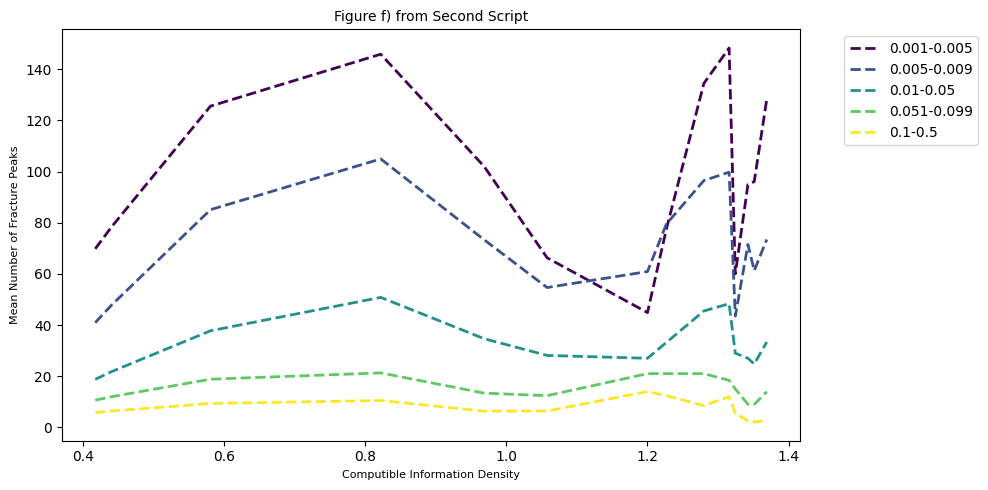

In [7]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.integrate import simpson
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Function to extract run number from folder name
def extract_run_number(folder_name):
    match = re.search(r'Test Run (\d+)', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None

# Function to find relevant peaks
def find_all_relevant_peaks(data, prominence_factor=0.01, drop_threshold=0.05):
    prominence = data['specific_compressive_stress'].max() * prominence_factor
    peaks, _ = find_peaks(data['specific_compressive_stress'], prominence=prominence)
    relevant_peaks = []
    for peak in peaks:
        peak_stress = data.iloc[peak]['specific_compressive_stress']
        for i in range(peak + 1, len(data)):
            if data.iloc[i]['specific_compressive_stress'] <= peak_stress * (1 - drop_threshold):
                relevant_peaks.append((data.iloc[peak]['specific_compressive_stress'], data.iloc[peak]['strain'], prominence_factor))
                break
    return relevant_peaks

# Sample data (for demonstration purposes)
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}


# Convert sample data to DataFrame
df_samples = pd.DataFrame(sample_data)

# Filter samples with names involving words
df_filtered = df_samples[df_samples['Sample Name'].apply(lambda x: isinstance(x, str))]

# Density of PLA in g/cm^3
density_pla = 1.25  # g/cm^3
# Convert density to kg/mm^3 for compatibility with voxel volume (1 mm^3)
density_pla_kg_per_mm3 = density_pla * 1e-3 * 1e-3 # g to kg and cm^-3 to mm^-3

# Net generation volume in mm^3
net_generation_volume_mm3 = 30e-3 * 30e-3 * 30e-3  # 30mm * 30mm * 30mm

# Set your main directory here
main_folder_path=main_folder_path
# List all subdirectories in the main directory
subfolders = [os.path.join(main_folder_path, f.name) for f in os.scandir(main_folder_path) if f.is_dir()]

# Filter and sort the subfolders based on the run number
filtered_subfolders = []
for folder in subfolders:
    run_number = extract_run_number(os.path.basename(folder))
    if run_number:
        filtered_subfolders.append((folder, run_number))

filtered_subfolders.sort(key=lambda x: x[1])

# Initialize a list to store the toughness and peak counts for each run
toughness_and_peak_counts = []
strengths = []

prominence_ranges = [
    (0.001, 0.005),
    (0.005, 0.009),
    (0.01, 0.05),
    (0.051, 0.099),
    (0.1, 0.5)
]

# Now process each filtered and sorted folder
for folder, run_number in filtered_subfolders:
    # Construct the file path
    file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    
    # Check if the file exists before trying to read it
    if os.path.isfile(file_path):
        # Read the data
        data = pd.read_csv(file_path, sep='\t', skiprows=7)
        
        # Calculate strain and stress
        data['strain'] = data['mm'] * (10**-3) / 0.036  # Original length in meters
        data['stress'] = (data['kN'] * 1000) / (30 * (10**-3) * 30 * (10**-3))  # Cross-sectional area in square meters

        # Calculate toughness using Simpson's rule for numerical integration
        toughness = simpson(y=data['stress'], x=data['strain'])

        # Calculate specific compressive stress
        sample_density = (df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0] * density_pla_kg_per_mm3) / net_generation_volume_mm3
        data['specific_compressive_stress'] = data['stress'] / sample_density

        # Ensure specific_compressive_stress column exists
        if 'specific_compressive_stress' not in data.columns:
            raise KeyError('specific_compressive_stress column not found in the DataFrame.')

        relevant_peaks_dict = {}
        peak_counts = []
        for prom_range in prominence_ranges:
            peaks_in_range = []
            for prom in np.linspace(prom_range[0], prom_range[1], 5):
                relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
                peaks_in_range.extend(relevant_peaks)
            num_peaks = len(peaks_in_range)
            peak_counts.append(num_peaks)
            relevant_peaks_dict[prom_range] = peaks_in_range

        # Append both toughness and the count of fracture peaks for all criteria
        toughness_and_peak_counts.append([run_number, toughness] + peak_counts)

# After processing all folders, compile toughness data into a DataFrame 
columns = ['Run Number', 'Toughness'] + [f'num_peaks_{r[0]}_{r[1]}' for r in prominence_ranges]
toughness_df = pd.DataFrame(toughness_and_peak_counts, columns=columns)

# Merge with the sample data
merged_df_2 = pd.merge(toughness_df, df_samples, on='Run Number', how='inner')

# Convert CID to numeric, drop rows with invalid CID values
merged_df_2['CID'] = pd.to_numeric(merged_df_2['CID'], errors='coerce')
merged_df_2 = merged_df_2.dropna(subset=['CID'])

# Plotting the right figure
prom_domain = (0.001, 0.5)
step = 0.05
frac = 0.3

plt.figure(figsize=(10, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(prominence_ranges)))
loess_results = []

for i, prom_range in enumerate(prominence_ranges):
    peak_column = f'num_peaks_{prom_range[0]}_{prom_range[1]}'
    results = merged_df_2[['CID', peak_column]].dropna().sort_values(by='CID')
    lowess = sm.nonparametric.lowess
    loess_result = lowess(results[peak_column], results['CID'], frac=frac)
    loess_results.append((loess_result, prom_range))

    ax2.plot(loess_result[:, 0], loess_result[:, 1], color=colors[i], linestyle='--', linewidth=2, label=f'{prom_range[0]}-{prom_range[1]}')

ax2.set_title('Figure f) from Second Script', fontsize=10)
ax2.set_xlabel('Computible Information Density', fontsize=8)
ax2.set_ylabel('Mean Number of Fracture Peaks', fontsize=8)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


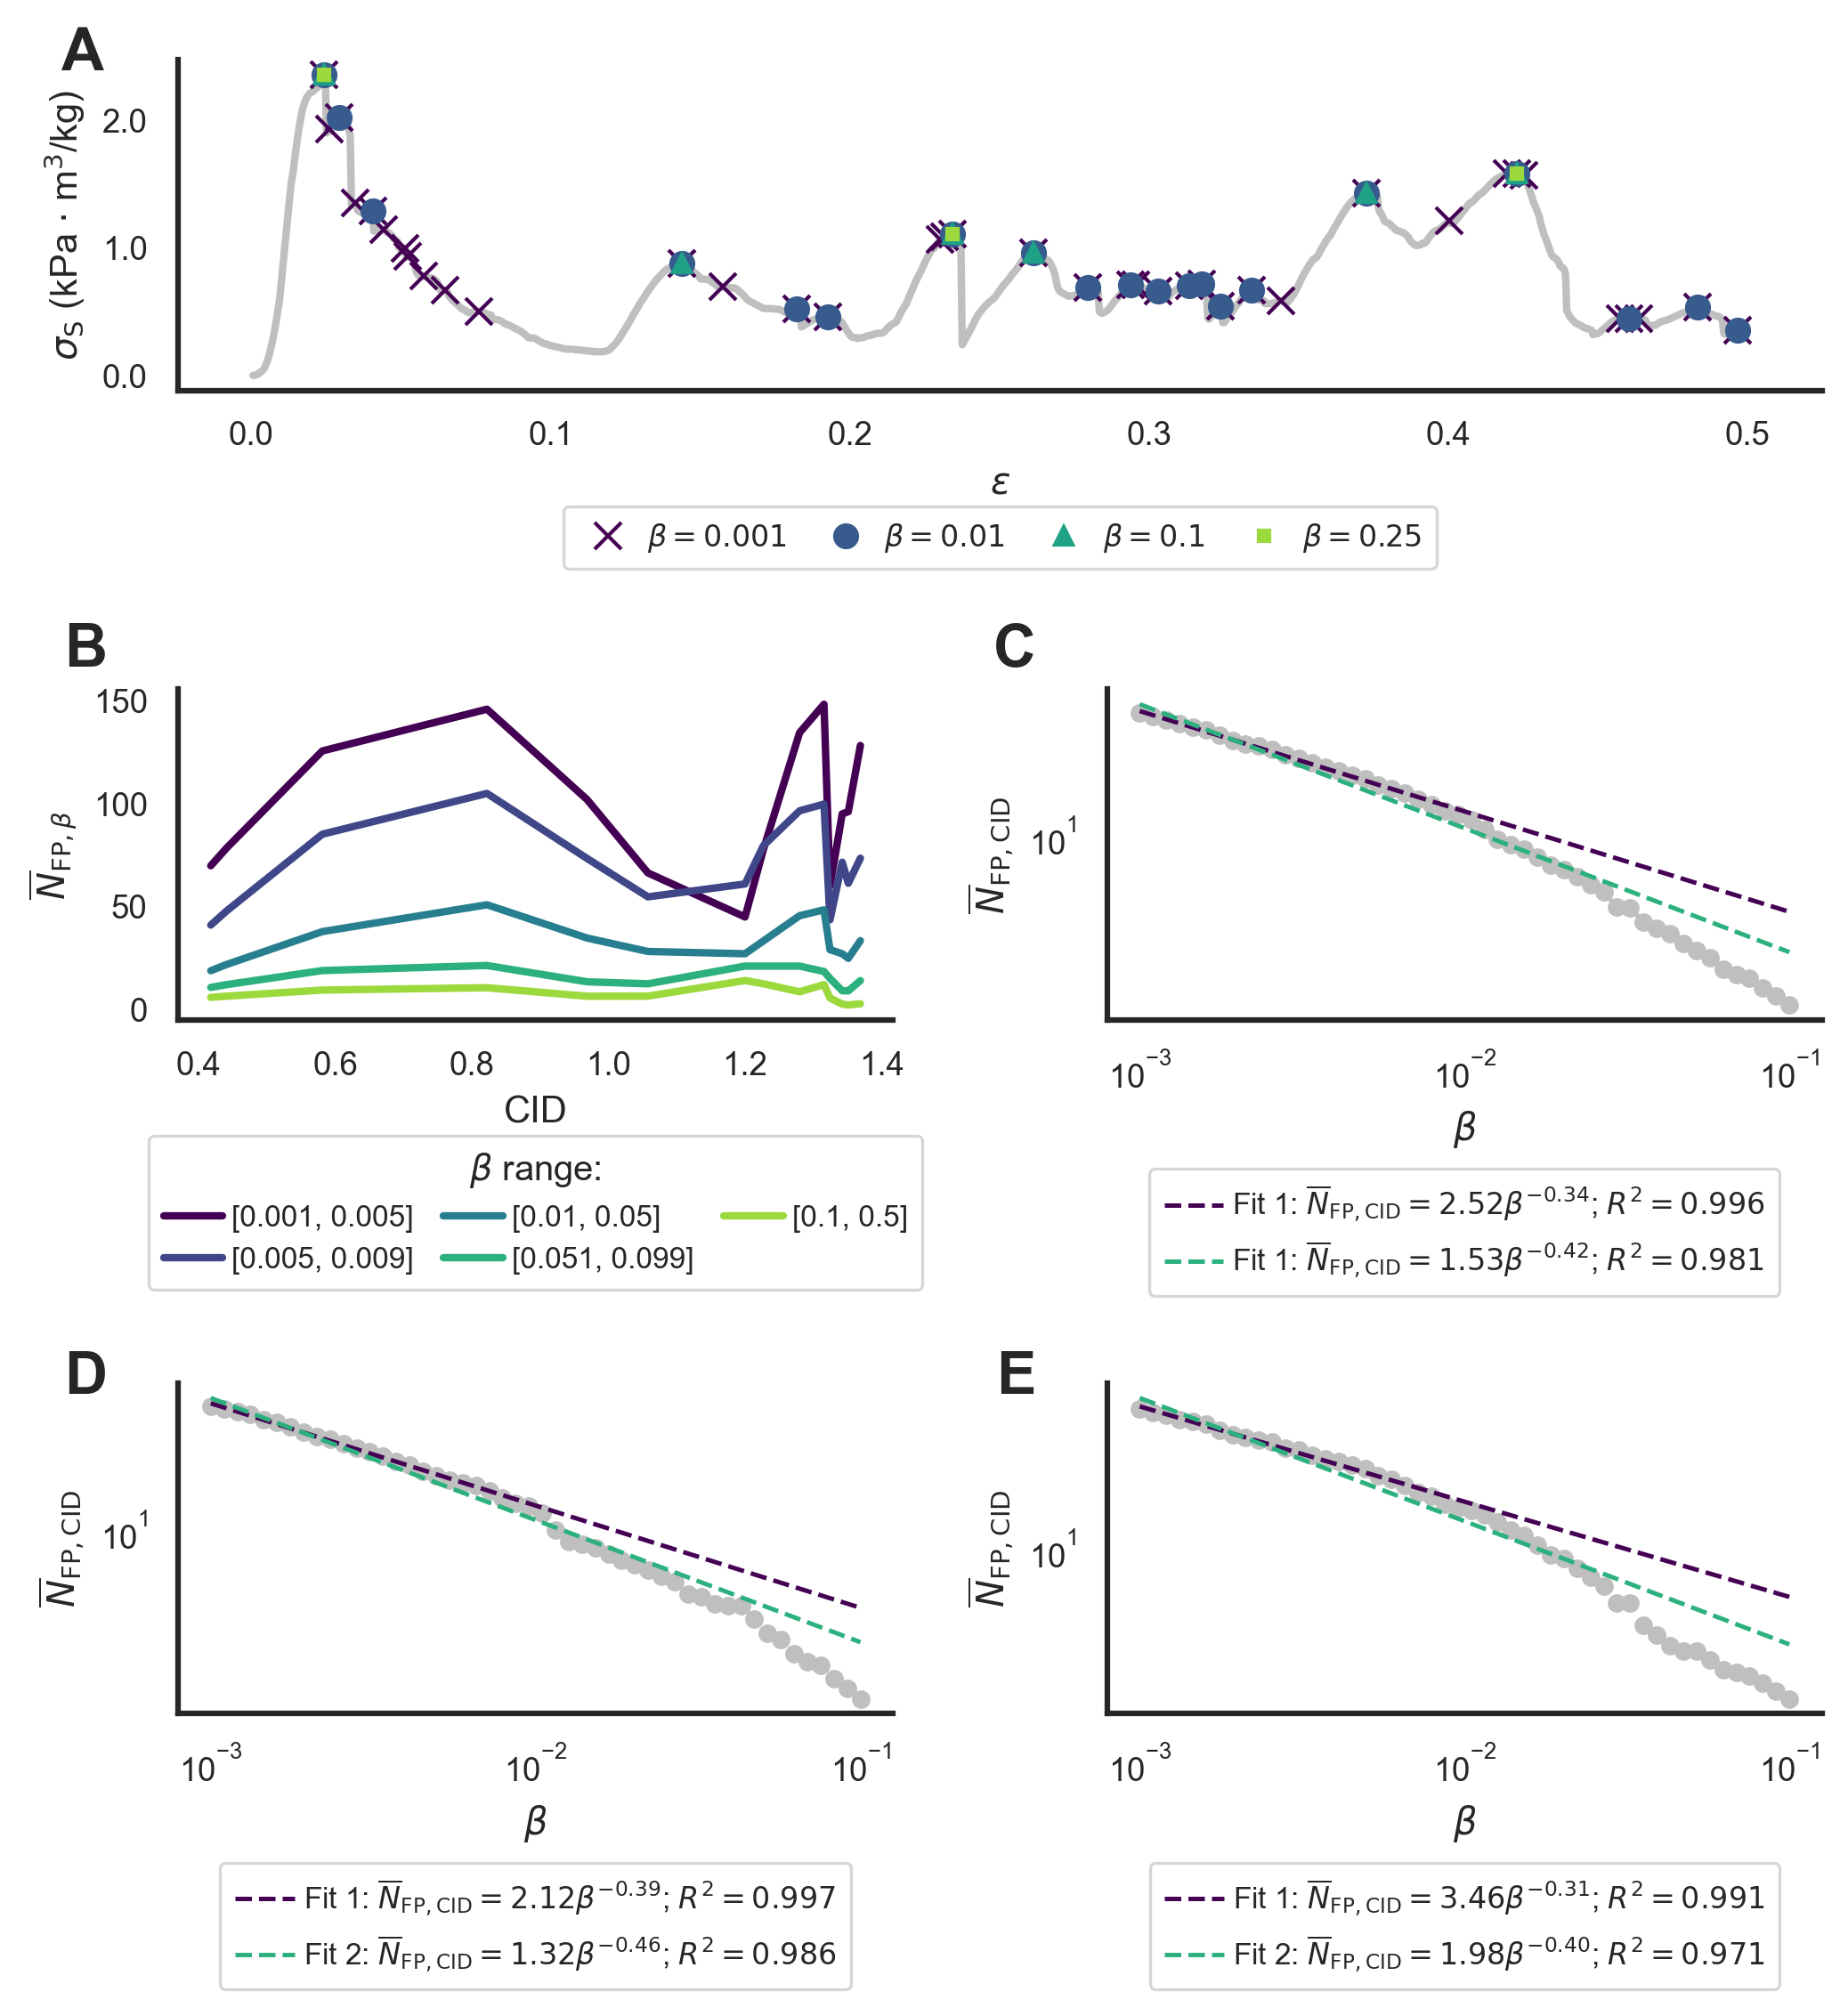

In [8]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.integrate import simpson
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

axesfontsize=10
legendfontsize=8
markersize=4
BIGfont=16

# Set seaborn style
sns.set(style='white', context='paper')
colors = plt.cm.viridis(np.linspace(0, 0.85, 4))

# Sample data
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}


# Convert sample data to DataFrame
df_samples = pd.DataFrame(sample_data)

# Filter samples with names involving words
df_filtered = df_samples[df_samples['Sample Name'].apply(lambda x: isinstance(x, str))]

# Density of PLA in g/cm^3
density_pla = 1.25  # g/cm^3
# Convert density to kg/mm^3 for compatibility with voxel volume (1 mm^3)
density_pla_kg_per_mm3 = density_pla * 1e-3 * 1e-3 # g to kg and cm^-3 to mm^-3

# Net generation volume in mm^3
net_generation_volume_mm3 = 30e-3 * 30e-3 * 30e-3  # 30mm * 30mm * 30mm

main_folder_path=main_folder_path

# Function to extract run number from folder name
def extract_run_number(folder_name):
    match = re.search(r'Test Run (\d+)', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None

# List all subdirectories in the main directory
subfolders = [os.path.join(main_folder_path, f.name) for f in os.scandir(main_folder_path) if f.is_dir()]

# Filter and sort the subfolders based on the run number
filtered_subfolders = []
for folder in subfolders:
    run_number = extract_run_number(os.path.basename(folder))
    if run_number:
        filtered_subfolders.append((folder, run_number))

filtered_subfolders.sort(key=lambda x: x[1])

# Define colormap for different numbers of branches using RGB values
branch_colormap = {
    'central branch': (0, 1, 0),         # Green
    'corner branch': (0.2, 0.8, 0.3),    # Dark Green
    '2 branches': (0.4, 0.6, 0.6),       # Darker Green
    '4 branches': (0.6, 0.4, 0.9),       # Blue-Green
    '5 branches': (0.8, 0.2, 1),         # Purple
    'ADF360GD 1000N': (0.8, 0.4, 0),     # Dark Orange
    'ADF360GD 200N': (1, 0.8, 0)         # Light Orange
}

# Function to find relevant peaks
def find_all_relevant_peaks(data, prominence_factor=0.01, drop_threshold=0.05):
    prominence = data['specific_compressive_stress'].max() * prominence_factor
    peaks, _ = find_peaks(data['specific_compressive_stress'], prominence=prominence)
    relevant_peaks = []
    for peak in peaks:
        peak_stress = data.iloc[peak]['specific_compressive_stress']
        for i in range(peak + 1, len(data)):
            if data.iloc[i]['specific_compressive_stress'] <= peak_stress * (1 - drop_threshold):
                relevant_peaks.append((data.iloc[peak]['specific_compressive_stress'], data.iloc[peak]['strain'], prominence_factor))
                break
    return relevant_peaks

# Variable to pick the run number for the first subfigure
selected_sample_number = 12  # Change this variable to pick the desired run number

# Plotting the figure with 2 square subplots on top and 1 rectangular subplot on the bottom
fig = plt.figure(figsize=(7.01, 8), dpi = 300)
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

############
#SUBFIGURE 1
############

# Plot a single gray curve from the dataset in the first script
ax1 = fig.add_subplot(gs[0, :])
for folder, run_number in filtered_subfolders:
    if run_number == selected_sample_number:
        file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    
        if os.path.isfile(file_path):
            # Read the data
            data = pd.read_csv(file_path, sep='\t', skiprows=7)
            
            # Calculate strain and stress
            data['strain'] = data['mm'] * (10**-3) / 0.036  # Original length in meters
            data['stress'] = (data['kN'] * 1000) / (30 * (10**-3) * 30 * (10**-3))  # stress in Pa
            
            # Calculate the mass of the sample
            voxel_count = df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0]
            mass_kg = voxel_count * density_pla_kg_per_mm3
            
            # Calculate the density of the sample
            sample_density = mass_kg / net_generation_volume_mm3
            
            # Calculate specific compressive stress
            data['specific_compressive_stress'] = data['stress'] / sample_density
            
            # Get the sample name
            sample_name = df_samples[df_samples['Run Number'] == run_number]['Sample Name'].values[0]
            
            # Plot the specific compressive stress-strain curve with a black color
            color = (.75,.75,.75,1)
            ax1.plot(data['strain'], data['specific_compressive_stress'], color=color, linewidth=2)
            
            # Find relevant peaks
            relevant_peaks_001 = find_all_relevant_peaks(data, prominence_factor=0.001)
            relevant_peaks_01 = find_all_relevant_peaks(data, prominence_factor=0.01)
            relevant_peaks_1 = find_all_relevant_peaks(data, prominence_factor=0.1)
            relevant_peaks_25 = find_all_relevant_peaks(data, prominence_factor=0.25)
            
            # Define colors and markers for each prominence
            peak_styles = {
                0.001: {'color': colors[0], 'marker': 'x', 'label': '$\\beta=0.001$', 'alpha': 1, 'markersize': markersize+3},
                0.01: {'color': colors[1], 'marker': 'o', 'label': '$\\beta=0.01$', 'alpha': 1, 'markersize': markersize+2},
                0.1: {'color': colors[2], 'marker': '^', 'label': '$\\beta=0.1$', 'alpha': 1, 'markersize': markersize+1},
                0.25: {'color': colors[3], 'marker': 's', 'label': '$\\beta=0.25$', 'alpha': 1, 'markersize': markersize-1}
            }
            
            # Mark peaks with different colors and markers
            for stress, strain, prominence in relevant_peaks_001:
                style = peak_styles[0.001]
                ax1.plot(strain, stress, linestyle='None', **style)
            
            for stress, strain, prominence in relevant_peaks_01:
                style = peak_styles[0.01]
                ax1.plot(strain, stress, linestyle='None', **style)
                
            for stress, strain, prominence in relevant_peaks_1:
                style = peak_styles[0.1]
                ax1.plot(strain, stress, linestyle='None', **style)
                
            for stress, strain, prominence in relevant_peaks_25:
                style = peak_styles[0.25]
                ax1.plot(strain, stress, linestyle='None', **style)
                
            break  # Only plot one gray curve

# Get the CID for the selected sample
cid = df_samples[df_samples['Run Number'] == selected_sample_number]['CID'].values[0]

# ax1.set_title(f'Sample $\sigma_{{\mathrm{{S}}}} - \\epsilon$ Curve for CT with CID = {cid}', fontsize=10)
ax1.set_xlabel('$\\epsilon$', fontsize=axesfontsize)
ax1.set_ylabel('$\sigma_{\mathrm{S}}$ (kPa $\cdot$ m$^3$/kg)', fontsize=axesfontsize)
#Define a custom formatter function that divides the tick value by 1000
def thousandth_formatter(x, pos):
    return f'{x / 1000:.1f}'  # Adjust the formatting as needed (e.g., .1f for one decimal place)

# Apply the formatter to the y-axis of ax1
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(thousandth_formatter))

# Create custom legend entries for the markers
custom_lines = [
    plt.Line2D([0], [0], color=colors[0], marker='x', linestyle='None', markersize=markersize+3, alpha=1, label='$\\beta=0.001$'),
    plt.Line2D([0], [0], color=colors[1], marker='o', linestyle='None', markersize=markersize+2, alpha=1, label='$\\beta=0.01$'),
    plt.Line2D([0], [0], color=colors[2], marker='^', linestyle='None', markersize=markersize+1, alpha=1, label='$\\beta=0.1$'),
    plt.Line2D([0], [0], color=colors[3], marker='s', linestyle='None', markersize=markersize-1, alpha=1, label='$\\beta=0.25$')
]
# Example adjustments to the legend
ax1.legend(
    handles=custom_lines, 
    loc='upper center',               # Automatically places the legend in the best location
    ncol=4,                   # Use 2 columns
    bbox_to_anchor=(.5, -.35), # Fine-tune the position if needed (e.g., move outside the plot)
    borderaxespad=0,        # Adjust space between legend and axes
    borderpad=0.5,              # Padding inside the legend box
    labelspacing=0.5,         # Space between legend entries
    columnspacing=1,          # Space between columns
    handletextpad=0.3,         # Space between the legend handle and text
    fontsize=legendfontsize
)

plt.tight_layout()


ax1.text(-0.045, 1.1, 'A', transform=ax1.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')


############
#SUBFIGURE 2
############
# Right square subplot
ax2 = fig.add_subplot(gs[1, 0])
colors = plt.cm.viridis(np.linspace(0, 0.85, len(prominence_ranges)))
loess_results = []

for i, prom_range in enumerate(prominence_ranges):
    peak_column = f'num_peaks_{prom_range[0]}_{prom_range[1]}'
    results = merged_df_2[['CID', peak_column]].dropna().sort_values(by='CID')
    lowess = sm.nonparametric.lowess
    loess_result = lowess(results[peak_column], results['CID'], frac=frac)
    loess_results.append((loess_result, prom_range))

    ax2.plot(loess_result[:, 0], loess_result[:, 1], color=colors[i], linestyle='-', linewidth=2, label=f'[{prom_range[0]}, {prom_range[1]}]')

# ax2.set_title('Mean Number of Fracture Peaks ($N_{FP}$) vs. Computible Information Density (CID)', fontsize=10)
ax2.set_xlabel('CID', fontsize=axesfontsize)
ax2.set_ylabel('$\overline{{N}}_{{\mathrm{{FP}}},\\beta}$', fontsize=axesfontsize)
ax2.legend(
    loc='upper center',               # Automatically places the legend in the best location
    ncol=3,                   # Use 2 columns
    bbox_to_anchor=(.5, -.35), # Fine-tune the position if needed (e.g., move outside the plot)
    borderaxespad=0,        # Adjust space between legend and axes
    borderpad=0.5,              # Padding inside the legend box
    labelspacing=0.5,         # Space between legend entries
    columnspacing=1,          # Space between columns
    handletextpad=0.3,         # Space between the legend handle and text
    fontsize=legendfontsize
).set_title('$\\beta$ range:')
ax2.text(-0.1, 1.2, 'B', transform=ax2.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')

# Bottom left rectangular subplot
ax3 = fig.add_subplot(gs[1, 1])

# Define the power law function
def power_law(x, a, n):
    return a * np.power(x, n)

# Function to calculate R^2
def calculate_r_squared(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# Generate more prominence factors for detailed analysis
prominence_factors_detailed = np.logspace(-3, -1, 50)  # Adjust the range and number of points as needed

# Create a dataframe to store the average number of peaks for each prominence factor
average_num_peaks_detailed = []

for prom in prominence_factors_detailed:
    peak_counts = []
    for folder, run_number in filtered_subfolders:
        file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
        
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path, sep='\t', skiprows=7)
            data['strain'] = data['mm'] * (10**-3) / 0.036
            data['stress'] = (data['kN'] * 1000) / (30 * (10**-3) * 30 * (10**-3))
            sample_density = (df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0] * density_pla_kg_per_mm3) / net_generation_volume_mm3
            data['specific_compressive_stress'] = data['stress'] / sample_density

            relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
            peak_counts.append(len(relevant_peaks))
    
    average_num_peaks_detailed.append(np.mean(peak_counts))

# Convert to numpy arrays for curve fitting
prominence_factors_detailed = np.array(prominence_factors_detailed)
average_num_peaks_detailed = np.array(average_num_peaks_detailed)

# Identify the cutoff index for prominence factor <= 10^-2
cutoff_index = np.searchsorted(prominence_factors_detailed, 1e-2, side='right')

# Fit the first set of points (all points with prominence factor <= 10^-2)
popt1, pcov1 = curve_fit(power_law, prominence_factors_detailed[:cutoff_index], average_num_peaks_detailed[:cutoff_index])
a1, n1 = popt1

# Fit all points
popt2, pcov2 = curve_fit(power_law, prominence_factors_detailed, average_num_peaks_detailed)
a2, n2 = popt2

# Calculate R^2 values
y_fit1 = power_law(prominence_factors_detailed[:cutoff_index], a1, n1)
r_squared1 = calculate_r_squared(average_num_peaks_detailed[:cutoff_index], y_fit1)

y_fit2 = power_law(prominence_factors_detailed, a2, n2)
r_squared2 = calculate_r_squared(average_num_peaks_detailed, y_fit2)

# Create the log-log plot
ax3.loglog(prominence_factors_detailed, average_num_peaks_detailed, marker='o', linestyle='-', color=color, markersize = markersize)

# Plot the fitted curves
x_fit = np.linspace(min(prominence_factors_detailed), max(prominence_factors_detailed), 100)

y_fit1_full = power_law(x_fit, a1, n1)
ax3.loglog(
    x_fit, 
    y_fit1_full, 
    linestyle='--', 
    color=colors[0], 
    label=fr'Fit 1: $\overline{{N}}_{{\mathrm{{FP, CID}}}} = {a1:.2f}\beta^{{{n1:.2f}}}$; $R^2 = {r_squared1:.3f}$'
)

y_fit2_full = power_law(x_fit, a2, n2)
ax3.loglog(
    x_fit, 
    y_fit2_full, 
    linestyle='--', 
    color=colors[3], 
    label=fr'Fit 1: $\overline{{N}}_{{\mathrm{{FP, CID}}}} = {a2:.2f}\beta^{{{n2:.2f}}}$; $R^2 = {r_squared2:.3f}$'
)

# ax3.set_title('Prominence Factor vs. $N_{FP}$', fontsize=10)
ax3.set_xlabel('$\\beta$', fontsize=10)
ax3.set_ylabel('$\\overline{N}_{\\mathrm{FP, CID}}$', fontsize=10)
ax3.legend(
    loc='upper center',               # Automatically places the legend in the best location
    ncol=1,                   # Use 2 columns
    bbox_to_anchor=(.5, -.45), # Fine-tune the position if needed (e.g., move outside the plot)
    borderaxespad=0,        # Adjust space between legend and axes
    borderpad=0.5,              # Padding inside the legend box
    labelspacing=0.5,         # Space between legend entries
    columnspacing=1,          # Space between columns
    handletextpad=0.3,         # Space between the legend handle and text
    fontsize=legendfontsize
)


ax3.text(-0.1, 1.2, 'C', transform=ax3.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')

# Remove grid from ax3
ax3.grid(False)

# Bottom right rectangular subplot
ax4 = fig.add_subplot(gs[2, 0])

# Create a dataframe to store the average number of peaks for each prominence factor for CIDs > 1.30
average_num_peaks_detailed_cid = []

for prom in prominence_factors_detailed:
    peak_counts = []
    for folder, run_number in filtered_subfolders:
        file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
        
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path, sep='\t', skiprows=7)
            data['strain'] = data['mm'] * (10**-3) / 0.036
            data['stress'] = (data['kN'] * 1000) / (30 * (10**-3) * 30 * (10**-3))
            sample_density = (df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0] * density_pla_kg_per_mm3) / net_generation_volume_mm3
            data['specific_compressive_stress'] = data['stress'] / sample_density
            
            # Filter by CID > 1.30
            cid_str = df_samples[df_samples['Run Number'] == run_number]['CID'].values[0]
            try:
                cid = float(cid_str)
                if cid > 1.30:
                    relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
                    peak_counts.append(len(relevant_peaks))
            except ValueError:
                # Handle the case where CID is not a number
                continue
    
    average_num_peaks_detailed_cid.append(np.mean(peak_counts))

# Convert to numpy arrays for curve fitting
average_num_peaks_detailed_cid = np.array(average_num_peaks_detailed_cid)

# Fit the first set of points (all points with prominence factor <= 10^-2)
popt1_cid, pcov1_cid = curve_fit(power_law, prominence_factors_detailed[:cutoff_index], average_num_peaks_detailed_cid[:cutoff_index])
a1_cid, n1_cid = popt1_cid

# Fit all points
popt2_cid, pcov2_cid = curve_fit(power_law, prominence_factors_detailed, average_num_peaks_detailed_cid)
a2_cid, n2_cid = popt2_cid

# Calculate R^2 values
y_fit1_cid = power_law(prominence_factors_detailed[:cutoff_index], a1_cid, n1_cid)
r_squared1_cid = calculate_r_squared(average_num_peaks_detailed_cid[:cutoff_index], y_fit1_cid)

y_fit2_cid = power_law(prominence_factors_detailed, a2_cid, n2_cid)
r_squared2_cid = calculate_r_squared(average_num_peaks_detailed_cid, y_fit2_cid)

# Create the log-log plot
ax4.loglog(prominence_factors_detailed, average_num_peaks_detailed_cid, marker='o', linestyle='', color=color, markersize = markersize)

# Plot the fitted curves
y_fit1_full_cid = power_law(x_fit, a1_cid, n1_cid)
ax4.loglog(x_fit, y_fit1_full_cid, linestyle='--', color=colors[0], label=fr'Fit 1: $\overline{{N}}_{{\mathrm{{FP, CID}}}}  = {a1_cid:.2f}\beta^{{{n1_cid:.2f}}}$; $R^2 = {r_squared1_cid:.3f}$')

y_fit2_full_cid = power_law(x_fit, a2_cid, n2_cid)
ax4.loglog(x_fit, y_fit2_full_cid, linestyle='--', color=colors[3], label=fr'Fit 2: $\overline{{N}}_{{\mathrm{{FP, CID}}}}  = {a2_cid:.2f}\beta^{{{n2_cid:.2f}}}$; $R^2 = {r_squared2_cid:.3f}$')

# ax4.set_title('Prominence Factor vs. Average Number of Fracture Peaks (CID > 1.30)', fontsize=10)
ax4.set_xlabel('$\\beta$', fontsize=10)
ax4.set_ylabel('$\\overline{N}_{\\mathrm{FP, CID}}$', fontsize=10)
ax4.legend(
    loc='upper center',               # Automatically places the legend in the best location
    ncol=1,                   # Use 2 columns
    bbox_to_anchor=(.5, -.45), # Fine-tune the position if needed (e.g., move outside the plot)
    borderaxespad=0,        # Adjust space between legend and axes
    borderpad=0.5,              # Padding inside the legend box
    labelspacing=0.5,         # Space between legend entries
    columnspacing=1,          # Space between columns
    handletextpad=0.3,         # Space between the legend handle and text
    fontsize=legendfontsize
)
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')

# Remove grid from ax4
ax4.grid(False)

# Bottom center rectangular subplot
ax5 = fig.add_subplot(gs[2, 1])

# Create a dataframe to store the average number of peaks for each prominence factor for CIDs < 1.30
average_num_peaks_detailed_cid_less = []

for prom in prominence_factors_detailed:
    peak_counts = []
    for folder, run_number in filtered_subfolders:
        file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
        
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path, sep='\t', skiprows=7)
            data['strain'] = data['mm'] * (10**-3) / 0.036
            data['stress'] = (data['kN'] * 1000) / (30 * (10**-3) * 30 * (10**-3))
            sample_density = (df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0] * density_pla_kg_per_mm3) / net_generation_volume_mm3
            data['specific_compressive_stress'] = data['stress'] / sample_density
            
            # Filter by CID < 1.30
            cid_str = df_samples[df_samples['Run Number'] == run_number]['CID'].values[0]
            try:
                cid = float(cid_str)
                if cid < 1.30:
                    relevant_peaks = find_all_relevant_peaks(data, prominence_factor=prom)
                    peak_counts.append(len(relevant_peaks))
            except ValueError:
                # Handle the case where CID is not a number
                continue
    
    average_num_peaks_detailed_cid_less.append(np.mean(peak_counts))

# Convert to numpy arrays for curve fitting
average_num_peaks_detailed_cid_less = np.array(average_num_peaks_detailed_cid_less)

# Fit the first set of points (all points with prominence factor <= 10^-2)
popt1_cid_less, pcov1_cid_less = curve_fit(power_law, prominence_factors_detailed[:cutoff_index], average_num_peaks_detailed_cid_less[:cutoff_index])
a1_cid_less, n1_cid_less = popt1_cid_less

# Fit all points
popt2_cid_less, pcov2_cid_less = curve_fit(power_law, prominence_factors_detailed, average_num_peaks_detailed_cid_less)
a2_cid_less, n2_cid_less = popt2_cid_less

# Calculate R^2 values
y_fit1_cid_less = power_law(prominence_factors_detailed[:cutoff_index], a1_cid_less, n1_cid_less)
r_squared1_cid_less = calculate_r_squared(average_num_peaks_detailed_cid_less[:cutoff_index], y_fit1_cid_less)

y_fit2_cid_less = power_law(prominence_factors_detailed, a2_cid_less, n2_cid_less)
r_squared2_cid_less = calculate_r_squared(average_num_peaks_detailed_cid_less, y_fit2_cid_less)

# Create the log-log plot
ax5.loglog(prominence_factors_detailed, average_num_peaks_detailed_cid_less, marker='o', linestyle='', color=color, markersize = markersize)

# Plot the fitted curves
y_fit1_full_cid_less = power_law(x_fit, a1_cid_less, n1_cid_less)
ax5.loglog(
    x_fit, 
    y_fit1_full_cid_less, 
    linestyle='--', 
    color=colors[0], 
    label=fr'Fit 1: $\overline{{N}}_{{\mathrm{{FP, CID}}}}  = {a1_cid_less:.2f}\beta^{{{n1_cid_less:.2f}}}$; $R^2 = {r_squared1_cid_less:.3f}$'
)

y_fit2_full_cid_less = power_law(x_fit, a2_cid_less, n2_cid_less)
ax5.loglog(
    x_fit, 
    y_fit2_full_cid_less, 
    linestyle='--', 
    color=colors[3], 
    label=fr'Fit 2: $\overline{{N}}_{{\mathrm{{FP, CID}}}}  = {a2_cid_less:.2f}\beta^{{{n2_cid_less:.2f}}}$; $R^2 = {r_squared2_cid_less:.3f}$'
)

# ax5.set_title('Prominence Factor vs. Average Number of Fracture Peaks (CID < 1.30)', fontsize=10)
ax5.set_xlabel('${\\beta}$', fontsize=10)
ax5.set_ylabel('$\\overline{N}_{\\mathrm{FP, CID}}$', fontsize=10)
ax5.legend(
    loc='upper center',               # Automatically places the legend in the best location
    ncol=1,                   # Use 2 columns
    bbox_to_anchor=(.5, -.45), # Fine-tune the position if needed (e.g., move outside the plot)
    borderaxespad=0,        # Adjust space between legend and axes
    borderpad=0.5,              # Padding inside the legend box
    labelspacing=0.5,         # Space between legend entries
    columnspacing=1,          # Space between columns
    handletextpad=0.3,         # Space between the legend handle and text
    fontsize=legendfontsize
)
ax5.text(-0.1, 1.1, 'E', transform=ax5.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')

# Remove grid from ax5
ax5.grid(False)

plt.tight_layout()

# Adjust the space between subplots
plt.subplots_adjust(
    hspace=1,  # Adjust the height space between subplots
    wspace=0.3   # Adjust the width space between subplots
)



# Fine-tune other axes if needed

pos1 = ax1.get_position()
pos2 = ax2.get_position()
pos3 = ax3.get_position()

ax1.set_position([pos1.x0, pos1.y0 - 0.05, pos1.width, pos1.height])

ax2.set_position([pos2.x0, pos2.y0 - 0.035, pos2.width, pos2.height])

ax3.set_position([pos3.x0, pos3.y0 - 0.035, pos3.width, pos3.height])

pos4 = ax4.get_position()
ax4.set_position([pos4.x0, pos4.y0-0.05, pos4.width, pos4.height])

pos5 = ax5.get_position()
ax5.set_position([pos5.x0, pos5.y0-0.05, pos5.width, pos5.height])

# Remove top and right spines for all subplots
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, you can also make the left and bottom spines a bit thicker for emphasis
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)



plt.show()
